<a href="https://colab.research.google.com/github/ahudson7/Emotional-Analysis-for-Toxicity-Prediction/blob/main/ConvosGoneAwry.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The code in this notebook is modified from the Cornell Conversational Analysis Toolkit (aka: Convokit), which can be found at https://github.com/CornellNLP/Cornell-Conversational-Analysis-Toolkit/blob/master/examples/conversations-gone-awry/Conversations_Gone_Awry_Prediction.ipynb.  

The paper associated with this work is:

Justine Zhang, Jonathan Chang, Cristian Danescu-Niculescu-Mizil, Lucas Dixon, Yiqing Hua, Dario Taraborelli, and Nithum Thain. 2018. Conversations gone awry: Detecting early signs of conversational failure. In Proceedings of the 56th Annual Meeting of the Association for Computational Linguistics (Volume 1: Long Papers), pages 1350–1361, Melbourne, Australia. Association for Computational Linguistics.



#Pre-processing Work


## Step 0: Setting up workspace

In [ ]:
pip install NRCLex # not necessary since importing pre-done CSV

In [ ]:
pip install convokit

In [ ]:
import os

import numpy as np
import pandas as pd
from scipy import stats

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, LeaveOneGroupOut
from sklearn.feature_selection import f_classif, SelectPercentile

from collections import defaultdict
from functools import partial
from multiprocessing import Pool

from convokit import download
from convokit.prompt_types import PromptTypeWrapper
from convokit import PolitenessStrategies
from convokit import Corpus

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

## Step 1: Loading the corpus

In [ ]:
# OPTION 1: DOWNLOAD CORPUS 
# UNCOMMENT THESE LINES TO DOWNLOAD CORPUS
# DATA_DIR = '/content/drive/MyDrive/CS510 - Adventures in NLP/Project/Notebook Testing'
# AWRY_ROOT_DIR = download('conversations-gone-awry-corpus', data_dir=DATA_DIR)
# AWRY_ROOT_DIR = download('conversations-gone-awry-cmv-corpus', data_dir=DATA_DIR)

# OPTION 2: READ PREVIOUSLY-DOWNLOADED CORPUS FROM DISK
# UNCOMMENT THIS LINE AND REPLACE WITH THE DIRECTORY WHERE THE TENNIS-CORPUS IS LOCATED
# AWRY_ROOT_DIR = '/content/drive/MyDrive/CS510 - Adventures in NLP/Project/Notebook Testing/conversations-gone-awry-corpus'
AWRY_ROOT_DIR = '/content/drive/MyDrive/CS510 - Adventures in NLP/Project/Notebook Testing/conversations-gone-awry-cmv-corpus'

awry_corpus = Corpus(AWRY_ROOT_DIR)
awry_corpus.load_info('utterance',['parsed'])

Dataset already exists at /content/drive/MyDrive/CS510 - Adventures in NLP/Project/Notebook Testing/conversations-gone-awry-cmv-corpus


In [ ]:
awry_corpus = awry_corpus.filter_conversations_by(lambda convo: convo.meta['annotation_year'] == '2018')
awry_corpus.print_summary_stats()

KeyError: ignored

# Feature development

## Step 2: Extract prompt types features

In [ ]:
# OPTION 1: DOWNLOAD CORPUS 
# UNCOMMENT THESE LINES TO DOWNLOAD CORPUS
# DATA_DIR = '/content/drive/MyDrive/CS510 - Adventures in NLP/Project/Notebook Testing'
# FULL_ROOT_DIR = download('tennis-corpus', data_dir=DATA_DIR)

# OPTION 2: READ PREVIOUSLY-DOWNLOADED CORPUS FROM DISK
# UNCOMMENT THIS LINE AND REPLACE WITH THE DIRECTORY WHERE THE TENNIS-CORPUS IS LOCATED
FULL_ROOT_DIR = '/content/drive/MyDrive/CS510 - Adventures in NLP/Project/Notebook Testing/tennis-corpus'

full_corpus = Corpus(FULL_ROOT_DIR)
full_corpus.load_info('utterance',['parsed'])

In [ ]:
# We encountered an issue with this package that occurs due to a known bug. The best workaround we found was to import and install it right it is needed in the next step.
# Sometimes it still runs into errors, and reloading the workbook and then retrying will often fix them.

import spacy 

spacy.cli.download("en_core_web_sm")

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [ ]:
pt_model = PromptTypeWrapper(n_types=6, use_prompt_motifs=False, root_only=False,
                            questions_only=False, enforce_caps=False, min_support=20, min_df=100,
                            svd__n_components=50, max_dist=1., random_state=1000)
pt_model.fit(full_corpus)

10000/163948 utterances processed
20000/163948 utterances processed
30000/163948 utterances processed
40000/163948 utterances processed
50000/163948 utterances processed
60000/163948 utterances processed
70000/163948 utterances processed
80000/163948 utterances processed
90000/163948 utterances processed
100000/163948 utterances processed
110000/163948 utterances processed
120000/163948 utterances processed
130000/163948 utterances processed
140000/163948 utterances processed
150000/163948 utterances processed
160000/163948 utterances processed
163948/163948 utterances processed
10000/163948 utterances processed
20000/163948 utterances processed
30000/163948 utterances processed
40000/163948 utterances processed
50000/163948 utterances processed
60000/163948 utterances processed
70000/163948 utterances processed
80000/163948 utterances processed
90000/163948 utterances processed
100000/163948 utterances processed
110000/163948 utterances processed
120000/163948 utterances processed
130

In [ ]:
pt_model.summarize(full_corpus, k=25)

TYPE 0
top prompt:
                    0         1         2  ...         4         5  type_id
will_*       0.568159  1.268891  1.041277  ...  1.020903  1.082567      0.0
will>*       0.626151  1.222001  1.013663  ...  1.063037  1.094487      0.0
going_are    0.630829  1.215016  1.063536  ...  1.145658  1.116865      0.0
going_'re    0.638768  1.263953  1.060312  ...  1.073161  1.093179      0.0
'll_*        0.651516  1.279967  1.062504  ...  1.030907  1.059195      0.0
going_*      0.653643  1.178902  1.097299  ...  1.147354  1.151417      0.0
be_*         0.662250  1.308188  0.985493  ...  1.006569  0.968070      0.0
be_will      0.666882  1.286708  1.090060  ...  0.950903  1.076193      0.0
have_will    0.678148  1.258543  1.080917  ...  1.018986  1.105346      0.0
going_play   0.692089  1.184499  1.067108  ...  1.005381  1.172970      0.0
what>will    0.692608  1.204820  1.115759  ...  1.152482  1.125475      0.0
going_be     0.692615  1.281817  1.122179  ...  1.038070  1.122539   

In [ ]:
TYPE_NAMES = ['Prompt: Casual', 'Prompt: Moderation', 'Prompt: Coordination', 'Prompt: Contention',
             'Prompt: Editing', 'Prompt: Procedures']

In [ ]:
awry_corpus = pt_model.transform(awry_corpus)

10000/42964 utterances processed
20000/42964 utterances processed
30000/42964 utterances processed
40000/42964 utterances processed
42964/42964 utterances processed


In [ ]:
prompt_dist_df = awry_corpus.get_vectors(name='prompt_types__prompt_dists.6', 
                                         as_dataframe=True)
type_ids = np.argmin(prompt_dist_df.values, axis=1)
mask  = np.min(prompt_dist_df.values, axis=1) >= 1.
type_ids[mask] = 6

NameError: ignored

In [ ]:
prompt_dist_df.head()

,type_0_dist,type_1_dist,type_2_dist,type_3_dist,type_4_dist,type_5_dist
146743638.12667.12652,1.067856,1.160137,0.683428,1.188180,1.000563,0.801900
146842219.12874.12874,1.165586,1.164032,0.865594,1.126720,0.951296,0.846169
146860774.13072.13072,1.085640,0.990856,0.599425,1.203014,1.074077,0.918509
143890867.11944.11926,1.017515,1.093424,0.767983,1.196536,1.068734,0.951620
143902946.11991.11991,1.020000,1.124164,0.780841,1.207956,1.009944,0.946839


In [ ]:
prompt_type_assignments = np.zeros((len(prompt_dist_df), prompt_dist_df.shape[1]+1))
prompt_type_assignments[np.arange(len(type_ids)),type_ids] = 1
prompt_type_assignment_df = pd.DataFrame(columns=np.arange(prompt_dist_df.shape[1]+1), index=prompt_dist_df.index, 
                                        data=prompt_type_assignments)
prompt_type_assignment_df = prompt_type_assignment_df[prompt_type_assignment_df.columns[:-1]]

In [ ]:
prompt_type_assignment_df.columns = TYPE_NAMES

In [ ]:
prompt_type_assignment_df.head()

,Prompt: Casual,Prompt: Moderation,Prompt: Coordination,Prompt: Contention,Prompt: Editing,Prompt: Procedures
146743638.12667.12652,0.0,0.0,1.0,0.0,0.0,0.0
146842219.12874.12874,0.0,0.0,0.0,0.0,0.0,1.0
146860774.13072.13072,0.0,0.0,1.0,0.0,0.0,0.0
143890867.11944.11926,0.0,0.0,1.0,0.0,0.0,0.0
143902946.11991.11991,0.0,0.0,1.0,0.0,0.0,0.0


## Step 3: Extract politeness strategies features

In [ ]:


ps = PolitenessStrategies(verbose=1000)
awry_corpus = ps.transform(awry_corpus)

In [ ]:
utterance_ids = awry_corpus.get_utterance_ids()
rows = []
for uid in utterance_ids:
    rows.append(awry_corpus.get_utterance(uid).meta["politeness_strategies"])
politeness_strategies = pd.DataFrame(rows, index=utterance_ids)

In [ ]:
politeness_strategies.head(10)

,feature_politeness_==Please==,feature_politeness_==Please_start==,feature_politeness_==HASHEDGE==,feature_politeness_==Indirect_(btw)==,feature_politeness_==Hedges==,feature_politeness_==Factuality==,feature_politeness_==Deference==,feature_politeness_==Gratitude==,feature_politeness_==Apologizing==,feature_politeness_==1st_person_pl.==,feature_politeness_==1st_person==,feature_politeness_==1st_person_start==,feature_politeness_==2nd_person==,feature_politeness_==2nd_person_start==,feature_politeness_==Indirect_(greeting)==,feature_politeness_==Direct_question==,feature_politeness_==Direct_start==,feature_politeness_==HASPOSITIVE==,feature_politeness_==HASNEGATIVE==,feature_politeness_==SUBJUNCTIVE==,feature_politeness_==INDICATIVE==
146743638.12652.12652,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
146743638.12667.12652,0,0,1,0,1,0,0,0,0,0,1,1,1,0,0,1,0,1,1,0,0
146842219.12874.12874,0,0,1,0,1,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0
146860774.13072.13072,0,0,1,0,1,0,0,1,0,0,1,1,1,0,0,0,1,1,1,0,0
143890867.11926.11926,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
143890867.11944.11926,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
143902946.11991.11991,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0
143945536.12065.12065,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0
144052463.12169.12169,0,0,1,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0
144065917.12226.12226,0,1,1,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0


## Step 3.5: Extracting emotional information

In [ ]:


import pandas as pd

file_path = '/content/drive/MyDrive/CS510 - Adventures in NLP/Project/Notebook Testing/CGA_emotion_df.csv'
emotion_df = pd.read_csv(file_path, index_col = 0)

'''
from nrclex import NRCLex
#from convokit import Corpus, download
corpus = Corpus(filename=download("conversations-gone-awry-corpus"))

count = 0

emotion_df = pd.DataFrame(columns=['fear', 'anger', 'anticipation', 'trust', 'surprise', 'positive', 'negative', 'sadness', 'disgust', 'joy'])

emotion_list = ['fear', 'anger', 'anticipation', 'trust', 'surprise', 'positive', 'negative', 'sadness', 'disgust', 'joy']

for utt in corpus.iter_utterances():
    emotion = NRCLex(utt.text)
    temp = []
    for k in emotion.affect_frequencies.keys():
        if k in emotion_list:
            emotion_df.loc[utt.id, k] = emotion.affect_frequencies[k]
        elif k == 'anticip':
            emotion_df.loc[utt.id, 'anticipation'] = emotion.affect_frequencies[k]
'''

'\nfrom nrclex import NRCLex\n#from convokit import Corpus, download\ncorpus = Corpus(filename=download("conversations-gone-awry-corpus"))\n\ncount = 0\n\nemotion_df = pd.DataFrame(columns=[\'fear\', \'anger\', \'anticipation\', \'trust\', \'surprise\', \'positive\', \'negative\', \'sadness\', \'disgust\', \'joy\'])\n\nemotion_list = [\'fear\', \'anger\', \'anticipation\', \'trust\', \'surprise\', \'positive\', \'negative\', \'sadness\', \'disgust\', \'joy\']\n\nfor utt in corpus.iter_utterances():\n    emotion = NRCLex(utt.text)\n    temp = []\n    for k in emotion.affect_frequencies.keys():\n        if k in emotion_list:\n            emotion_df.loc[utt.id, k] = emotion.affect_frequencies[k]\n        elif k == \'anticip\':\n            emotion_df.loc[utt.id, \'anticipation\'] = emotion.affect_frequencies[k]\n'

In [ ]:
emotion_df.head(10)

,fear,anger,anticipation,trust,surprise,positive,negative,sadness,disgust,joy
ID,,,,,,,,,,
146743638.12652.12652,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000
146743638.12667.12652,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,0.333333,0.000000,0.000
146842219.12874.12874,0.000000,0.000000,0.000000,0.285714,0.142857,0.571429,0.000000,0.000000,0.000000,0.000
146860774.13072.13072,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000
143890867.11926.11926,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000
143890867.11944.11926,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000
143902946.11991.11991,0.000000,0.000000,0.000000,0.000000,0.000000,0.666667,0.333333,0.000000,0.000000,0.000
143945536.12065.12065,0.125000,0.125000,0.000000,0.125000,0.000000,0.125000,0.125000,0.125000,0.125000,0.125
144052463.12169.12169,0.333333,0.000000,0.000000,0.000000,0.000000,0.333333,0.333333,0.000000,0.000000,0.000


## Step 4: Create pair data

In [ ]:
# first, we need to directly map comment IDs to their conversations. We'll build a DataFrame to do this
comment_ids = []
convo_ids = []
timestamps = []
page_ids = []
for conversation in awry_corpus.iter_conversations():
    for comment in conversation.iter_utterances():
        # section headers are included in the dataset for completeness, but for prediction we need to ignore
        # them as they are not utterances
        if not comment.meta["is_section_header"]:
            comment_ids.append(comment.id)
            convo_ids.append(comment.root)
            timestamps.append(comment.timestamp)
            page_ids.append(conversation.meta["page_id"])
comment_df = pd.DataFrame({"conversation_id": convo_ids, "timestamp": timestamps, "page_id": page_ids}, index=comment_ids)

# we'll do our construction using awry conversation ID's as the reference key
awry_convo_ids = set()
# these dicts will then all be keyed by awry ID
good_convo_map = {}
page_id_map = {}
for conversation in awry_corpus.iter_conversations():
    if conversation.meta["conversation_has_personal_attack"] and conversation.id not in awry_convo_ids:
        awry_convo_ids.add(conversation.id)
        good_convo_map[conversation.id] = conversation.meta["pair_id"]
        page_id_map[conversation.id] = conversation.meta["page_id"]
awry_convo_ids = list(awry_convo_ids)
pairs_df = pd.DataFrame({"bad_conversation_id": awry_convo_ids,
                         "conversation_id": [good_convo_map[cid] for cid in awry_convo_ids],
                         "page_id": [page_id_map[cid] for cid in awry_convo_ids]})
# finally, we will augment the pairs dataframe with the IDs of the first and second comment for both
# the bad and good conversation. This will come in handy for constructing the feature matrix.
first_ids = []
second_ids = []
first_ids_bad = []
second_ids_bad = []
for row in pairs_df.itertuples():
    # "first two" is defined in terms of time of posting
    comments_sorted = comment_df[comment_df.conversation_id==row.conversation_id].sort_values(by="timestamp")
    first_ids.append(comments_sorted.iloc[0].name)
    second_ids.append(comments_sorted.iloc[1].name)
    comments_sorted_bad = comment_df[comment_df.conversation_id==row.bad_conversation_id].sort_values(by="timestamp")
    first_ids_bad.append(comments_sorted_bad.iloc[0].name)
    second_ids_bad.append(comments_sorted_bad.iloc[1].name)
pairs_df = pairs_df.assign(first_id=first_ids, second_id=second_ids, 
                           bad_first_id=first_ids_bad, bad_second_id=second_ids_bad)

## Step 5: Comparing features exhibited

In [ ]:
def clean_feature_name(feat):
    new_feat = feat.replace('feature_politeness','').replace('==','').replace('_', ' ')
    split = new_feat.split()
    first, rest = split[0], ' '.join(split[1:]).lower()
    if first[0].isalpha():
        first = first.title()
    if 'Hashedge' in first:
        return 'Hedge (lexicon)'
    if 'Hedges' in first:
        return 'Hedge (dep. tree)'
    if 'greeting' in feat:
        return 'Greetings'
    cleaner_str = first + ' ' + rest
#     cleaner_str = cleaner_str.replace('2nd', '2$\mathregular{^{nd}}$').replace('1st', '1$\mathregular{^{st}}$')
    return cleaner_str

In [ ]:
politeness_strategies_display = politeness_strategies[[col for col in politeness_strategies.columns 
                  if col not in ['feature_politeness_==HASNEGATIVE==', 'feature_politeness_==HASPOSITIVE==']]].copy()
politeness_strategies_display.columns = [clean_feature_name(col) for col in politeness_strategies_display.columns]

all_features = politeness_strategies_display.join(prompt_type_assignment_df)

tox_first_comment_features =pairs_df[['bad_first_id']].join(all_features, how='left', on='bad_first_id')[all_features.columns]
ntox_first_comment_features =pairs_df[['first_id']].join(all_features, how='left', on='first_id')[all_features.columns]

tox_second_comment_features =pairs_df[['bad_second_id']].join(all_features, how='left', on='bad_second_id')[all_features.columns]
ntox_second_comment_features =pairs_df[['second_id']].join(all_features, how='left', on='second_id')[all_features.columns]


def get_p_stars(x):
    if x < .001: return '***'
    elif x < .01: return '**'
    elif x < .05: return '*'
    else: return ''
def compare_tox(df_ntox, df_tox,  min_n=0):
    cols = df_ntox.columns
    num_feats_in_tox = df_tox[cols].sum().astype(int).rename('num_feat_tox')
    num_nfeats_in_tox = (1 - df_tox[cols]).sum().astype(int).rename('num_nfeat_tox')
    num_feats_in_ntox = df_ntox[cols].sum().astype(int).rename('num_feat_ntox')
    num_nfeats_in_ntox = (1 - df_ntox[cols]).sum().astype(int).rename('num_nfeat_ntox')
    prop_tox = df_tox[cols].mean().rename('prop_tox')
    ref_prop_ntox = df_ntox[cols].mean().rename('prop_ntox')
    n_tox = len(df_tox)
    df = pd.concat([
        num_feats_in_tox, 
        num_nfeats_in_tox,
        num_feats_in_ntox,
        num_nfeats_in_ntox,
        prop_tox,
        ref_prop_ntox,
    ], axis=1)
    df['num_total'] = df.num_feat_tox + df.num_feat_ntox
    df['log_odds'] = np.log(df.num_feat_tox) - np.log(df.num_nfeat_tox) \
        + np.log(df.num_nfeat_ntox) - np.log(df.num_feat_ntox)
    df['abs_log_odds'] = np.abs(df.log_odds)
    df['binom_p'] = df.apply(lambda x: stats.binom_test(x.num_feat_tox, n_tox, x.prop_ntox), axis=1)
    df = df[df.num_total >= min_n]
    df['p'] = df['binom_p'].apply(lambda x: '%.3f' % x)
    df['pstars'] = df['binom_p'].apply(get_p_stars)
    return df.sort_values('log_odds', ascending=False)

first_comparisons = compare_tox(ntox_first_comment_features, tox_first_comment_features)
second_comparisons = compare_tox(ntox_second_comment_features, tox_second_comment_features)

In [ ]:
# we are now ready to plot these comparisons. the following (rather intimidating) helper function 
# produces a nicely-formatted plot:
def draw_figure(ax, first_cmp, second_cmp, title='', prompt_types=6, min_log_odds=.2, min_freq=50,xlim=.85):

    # selecting and sorting the features to plot, given minimum effect sizes and statistical significance
    frequent_feats = first_cmp[first_cmp.num_total >= min_freq].index.union(second_cmp[second_cmp.num_total >= min_freq].index)
    lrg_effect_feats = first_cmp[(first_cmp.abs_log_odds >= .2)
                                & (first_cmp.binom_p < .05)].index.union(second_cmp[(second_cmp.abs_log_odds >= .2)
                                                                                  & (second_cmp.binom_p < .05)].index)
    feats_to_include = frequent_feats.intersection(lrg_effect_feats)
    feat_order = sorted(feats_to_include, key=lambda x: first_cmp.loc[x].log_odds, reverse=True)

    # parameters determining the look of the figure
    colors = ['darkorchid', 'seagreen']
    shapes = ['d', 's']    
    eps = .02
    star_eps = .035
    xlim = xlim
    min_log = .2
    gap_prop = 2
    label_size = 14
    title_size=18
    radius = 144
    features = feat_order
    ax.invert_yaxis()
    ax.plot([0,0], [0, len(features)/gap_prop], color='black')
    
    # for each figure we plot the point according to effect size in the first and second comment, 
    # and add axis labels denoting statistical significance
    yticks = []
    yticklabels = []
    for f_idx, feat in enumerate(features):
        curr_y = (f_idx + .5)/gap_prop
        yticks.append(curr_y)
        try:
            
            first_p = first_cmp.loc[feat].binom_p
            second_p = second_cmp.loc[feat].binom_p            
            if first_cmp.loc[feat].abs_log_odds < min_log:
                first_face = "white"
            elif first_p >= 0.05:
                first_face = 'white'
            else:
                first_face = colors[0]
            if second_cmp.loc[feat].abs_log_odds < min_log:
                second_face = "white"
            elif second_p >= 0.05:
                second_face = 'white'
            else:
                second_face = colors[1]
            ax.plot([-1 * xlim, xlim], [curr_y, curr_y], '--', color='grey', zorder=0, linewidth=.5)
            
            ax.scatter([first_cmp.loc[feat].log_odds], [curr_y + eps], s=radius, edgecolor=colors[0], marker=shapes[0],
                        zorder=20, facecolors=first_face)
            ax.scatter([second_cmp.loc[feat].log_odds], [curr_y + eps], s=radius, edgecolor=colors[1], marker=shapes[1], 
                       zorder=10, facecolors=second_face)
            
            first_pstr_len = len(get_p_stars(first_p))
            second_pstr_len = len(get_p_stars(second_p))
            p_str = np.array([' '] * 8)
            if first_pstr_len > 0:
                p_str[:first_pstr_len] = '*'
            if second_pstr_len > 0:
                p_str[-second_pstr_len:] = '⁺'
            
            feat_str = feat + '\n' + ''.join(p_str)
            yticklabels.append(feat_str)
        except Exception as e:
            yticklabels.append('')
    
    # add the axis labels
    ax.set_xlabel('log-odds ratio', fontsize=14, family='serif')
    ax.set_xticks([-xlim-.05, -.5, 0, .5, xlim])
    ax.set_xticklabels(['on-track', -.5, 0, .5, 'awry'], fontsize=14, family='serif')
    ax.set_yticks(yticks)
    ax.set_yticklabels(yticklabels, fontsize=16, family='serif')
    ax.tick_params(axis='both',  which='both', bottom='off',  top='off',left='off')
    if title != '':
        ax.text(0, (len(features) + 2.25)/ gap_prop, title, fontsize=title_size, family='serif',horizontalalignment='center',)
    return feat_order

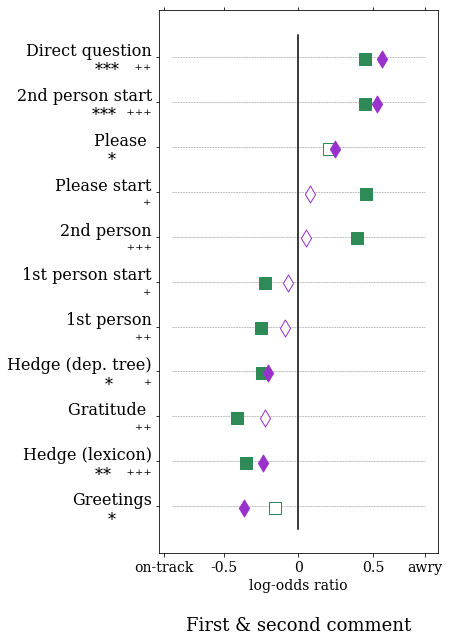

In [ ]:
f, ax = plt.subplots(1,1, figsize=(5,10))
_ = draw_figure(ax, first_comparisons, second_comparisons, 'First & second comment')

## Step 6: Construct feature matrix

In [ ]:
def features_for_convo(convo_id, first_comment_id, second_comment_id):

    # get prompt type features
    try:
        first_prompts = prompt_dist_df.loc[first_comment_id]
    except:
        first_prompts = pd.Series(data=np.ones(len(prompt_dist_df.columns)), index=prompt_dist_df.columns)
    try:
        second_prompts = prompt_dist_df.loc[second_comment_id].rename({c: c + "_second" for c in prompt_dist_df.columns})
    except:
        second_prompts = pd.Series(data=np.ones(len(prompt_dist_df.columns)), index=[c + "_second" for c in prompt_dist_df.columns])
    prompts = first_prompts.append(second_prompts)
    # get politeness strategies features
    first_politeness = politeness_strategies.loc[first_comment_id]
    second_politeness = politeness_strategies.loc[second_comment_id].rename({c: c + "_second" for c in politeness_strategies.columns})
    politeness = first_politeness.append(second_politeness)
    #return politeness.append(prompts)

    ##################################################    
    # get emotional strategies features - added by me!
    temp_df = politeness.append(prompts)

    first_emotional = emotion_df.loc[first_comment_id]
    second_emotional = emotion_df.loc[second_comment_id].rename({c: c + "_second" for c in emotion_df.columns})
    emotional = first_emotional.append(second_emotional)
    
    return emotional.append(temp_df)
    ##################################################

convo_ids = np.concatenate((pairs_df.conversation_id.values, pairs_df.bad_conversation_id.values))
feats = [features_for_convo(row.conversation_id, row.first_id, row.second_id) for row in pairs_df.itertuples()] + \
        [features_for_convo(row.bad_conversation_id, row.bad_first_id, row.bad_second_id) for row in pairs_df.itertuples()]
feature_table = pd.DataFrame(data=np.vstack([f.values for f in feats]), columns=feats[0].index, index=convo_ids)

# in the paper, we dropped the sentiment lexicon based features (HASPOSITIVE and HASNEGATIVE), opting
# to instead use them as a baseline. We do this here as well to be consistent with the paper.
feature_table = feature_table.drop(columns=["feature_politeness_==HASPOSITIVE==",
                                            "feature_politeness_==HASNEGATIVE==",
                                            "feature_politeness_==HASPOSITIVE==_second",
                                            "feature_politeness_==HASNEGATIVE==_second"])

feature_table.head(5)

,fear,anger,anticipation,trust,surprise,positive,negative,sadness,disgust,joy,fear_second,anger_second,anticipation_second,trust_second,surprise_second,positive_second,negative_second,sadness_second,disgust_second,joy_second,feature_politeness_==Please==,feature_politeness_==Please_start==,feature_politeness_==HASHEDGE==,feature_politeness_==Indirect_(btw)==,feature_politeness_==Hedges==,feature_politeness_==Factuality==,feature_politeness_==Deference==,feature_politeness_==Gratitude==,feature_politeness_==Apologizing==,feature_politeness_==1st_person_pl.==,feature_politeness_==1st_person==,feature_politeness_==1st_person_start==,feature_politeness_==2nd_person==,feature_politeness_==2nd_person_start==,feature_politeness_==Indirect_(greeting)==,feature_politeness_==Direct_question==,feature_politeness_==Direct_start==,feature_politeness_==SUBJUNCTIVE==,feature_politeness_==INDICATIVE==,feature_politeness_==Please==_second,feature_politeness_==Please_start==_second,feature_politeness_==HASHEDGE==_second,feature_politeness_==Indirect_(btw)==_second,feature_politeness_==Hedges==_second,feature_politeness_==Factuality==_second,feature_politeness_==Deference==_second,feature_politeness_==Gratitude==_second,feature_politeness_==Apologizing==_second,feature_politeness_==1st_person_pl.==_second,feature_politeness_==1st_person==_second,feature_politeness_==1st_person_start==_second,feature_politeness_==2nd_person==_second,feature_politeness_==2nd_person_start==_second,feature_politeness_==Indirect_(greeting)==_second,feature_politeness_==Direct_question==_second,feature_politeness_==Direct_start==_second,feature_politeness_==SUBJUNCTIVE==_second,feature_politeness_==INDICATIVE==_second,type_0_dist,type_1_dist,type_2_dist,type_3_dist,type_4_dist,type_5_dist,type_0_dist_second,type_1_dist_second,type_2_dist_second,type_3_dist_second,type_4_dist_second,type_5_dist_second
267643437.10093.10093,0.000000,0.078947,0.052632,0.289474,0.0,0.421053,0.078947,0.000000,0.052632,0.026316,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.087562,1.132511,0.663323,1.180724,0.994041,0.803805,0.983872,1.225899,0.689662,1.167138,1.018927,0.768638
100082597.1198.1198,0.000000,0.400000,0.000000,0.000000,0.0,0.000000,0.400000,0.200000,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.123591,1.081178,0.822368,1.095293,1.078284,0.985907,1.030434,1.037119,0.836787,1.117435,1.091464,1.027288
316091311.7720.7582,0.222222,0.166667,0.000000,0.000000,0.0,0.111111,0.333333,0.111111,0.055556,0.000000,0.000000,0.000000,0.000000,0.250000,0.000000,0.000000,0.250000,0.250000,0.250000,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.135853,1.075082,0.733606,1.179917,1.062867,0.827480,1.017688,1.232035,0.841326,1.052726,1.003982,0.778965
669153537.3274.3282,0.000000,0.000000,0.129032,0.322581,0.0,0.483871,0.000000,0.000000,0.000000,0.064516,0.000000,0.000000,0.200000,0.200000,0.000000,0.400000,0.000000,0.000000,0.000000,0.2,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.999090,1.184040,0.650589,1.199108,0.992163,0.796000,0.921117,1.126415,0.696795,1.199050,1.047139,0.954811
78498044.29904.29904,0.000000,0.111111,0.111111,0.000000,0.0,0.333333,0.111111,0.111111,0.111111,0.111111,0.052632,0.157895,0.052632,0.157895,0.052632,0.157895,0.210526,0.105263,0.052632,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0

# Prediction

## Step 7: Setting up prediction functions

In [ ]:
def mode(seq):
    vals, counts = np.unique(seq, return_counts=True)
    return vals[np.argmax(counts)]

def run_pred_single(inputs, X, y):
    f_idx, (train_idx, test_idx) = inputs
    
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    base_clf = Pipeline([("scaler", StandardScaler()), ("featselect", SelectPercentile(f_classif, 10)), ("logreg", LogisticRegression(solver='liblinear'))])
    clf = GridSearchCV(base_clf, {"logreg__C": [10**i for i in range(-4,4)], "featselect__percentile": list(range(10, 110, 10))}, cv=3)

    clf.fit(X_train, y_train)
    
    y_scores = clf.predict_proba(X_test)[:,1]
    y_pred = clf.predict(X_test)
    
    feature_weights = clf.best_estimator_.named_steps["logreg"].coef_.flatten()
    feature_mask = clf.best_estimator_.named_steps["featselect"].get_support()
    
    hyperparams = clf.best_params_
    
    return (y_pred, y_scores, feature_weights, hyperparams, feature_mask)

def run_pred(X, y, fnames, groups):
    feature_weights = {}
    scores = np.asarray([np.nan for i in range(len(y))])
    y_pred = np.zeros(len(y))
    hyperparameters = defaultdict(list)
    splits = list(enumerate(LeaveOneGroupOut().split(X, y, groups)))
    accs = []
        
    with Pool(os.cpu_count()) as p:
        prediction_results = p.map(partial(run_pred_single, X=X, y=y), splits)
        
    fselect_pvals_all = []
    for i in range(len(splits)):
        f_idx, (train_idx, test_idx) = splits[i]
        y_pred_i, y_scores_i, weights_i, hyperparams_i, mask_i = prediction_results[i]
        y_pred[test_idx] = y_pred_i
        scores[test_idx] = y_scores_i
        feature_weights[f_idx] = np.asarray([np.nan for _ in range(len(fnames))])
        feature_weights[f_idx][mask_i] = weights_i
        for param in hyperparams_i:
            hyperparameters[param].append(hyperparams_i[param])   
    
    acc = np.mean(y_pred == y)
    pvalue = stats.binom_test(sum(y_pred == y), n=len(y), alternative="greater")
                
    coef_df = pd.DataFrame(feature_weights, index=fnames)
    coef_df['mean_coef'] = coef_df.apply(np.nanmean, axis=1)
    coef_df['std_coef'] = coef_df.apply(np.nanstd, axis=1)
    return acc, coef_df[['mean_coef', 'std_coef']], scores, pd.DataFrame(hyperparameters), pvalue

def get_labeled_pairs(pairs_df):
    paired_labels = []
    c0s = []
    c1s = []
    page_ids = []
    for i, row in enumerate(pairs_df.itertuples()):
        if i % 2 == 0:
            c0s.append(row.conversation_id)
            c1s.append(row.bad_conversation_id)
        else:
            c0s.append(row.bad_conversation_id)
            c1s.append(row.conversation_id)
        paired_labels.append(i%2)
        page_ids.append(row.page_id)
    return pd.DataFrame({"c0": c0s, "c1": c1s,"first_convo_toxic": paired_labels, "page_id": page_ids})

def get_feature_subset(labeled_pairs_df, feature_list):
    emotion_names = ['fear', 'anger', 'anticipation', 'trust', 'surprise', 'positive', 'negative', 'sadness', 'disgust', 'joy', 
                    'fear_second', 'anger_second', 'anticipation_second', 'trust_second', 'surprise_second', 'positive_second', 'negative_second', 'sadness_second', 'disgust_second', 'joy_second']
    prompt_type_names = ["type_%d_dist" % i for i in range(6)] + ["type_%d_dist_second" % i for i in range(6)]
    politeness_names = [f for f in feature_table.columns if ((f not in prompt_type_names) and (f not in emotion_names))]
    
    #print(emotion_names)
    #print(prompt_type_names)
    #print(politeness_names)

    features_to_use = []
    if "prompt_types" in feature_list:
        features_to_use += prompt_type_names
    if "politeness_strategies" in feature_list:
        features_to_use += politeness_names
    if "emotion_analytics" in feature_list:
        features_to_use += emotion_names
    
    feature_subset = feature_table[features_to_use]
    
    c0_feats = feature_subset.loc[labeled_pairs_df.c0].values
    c1_feats = feature_subset.loc[labeled_pairs_df.c1].values

    return c0_feats, c1_feats, features_to_use

def run_pipeline(feature_set):
    print("Running prediction task for feature set", "+".join(feature_set))
    print("Generating labels...")
    labeled_pairs_df = get_labeled_pairs(pairs_df)
    print("Computing paired features...")
    X_c0, X_c1, feature_names = get_feature_subset(labeled_pairs_df, feature_set)
    X = X_c1 - X_c0
    print("Using", X.shape[1], "features")
    y = labeled_pairs_df.first_convo_toxic.values
    print("Running leave-one-page-out prediction...")
    accuracy, coefs, scores, hyperparams, pvalue = run_pred(X, y, feature_names, labeled_pairs_df.page_id)
    print("Accuracy:", accuracy)
    print("p-value: %.4e" % pvalue)
    print("C (mode):", mode(hyperparams.logreg__C))
    print("Percent of features (mode):", mode(hyperparams.featselect__percentile))
    print("Coefficents:")
    print(coefs.sort_values(by="mean_coef"))
    return accuracy

## Step 8: Prediction

In [ ]:
#feature_combos = [["emotion_analytics"],["politeness_strategies"], ["prompt_types"], ["politeness_strategies", "prompt_types"]]
#feature_combos = [["politeness_strategies", "emotion_analytics"], ["prompt_types", "emotion_analytics"]]
feature_combos = [["politeness_strategies"], ["prompt_types"], ["emotion_analytics"], ["politeness_strategies", "prompt_types"], ["politeness_strategies", "emotion_analytics"], ["prompt_types", "emotion_analytics"], ["politeness_strategies", "prompt_types", "emotion_analytics"]]
combo_names = []
accs = []
for combo in feature_combos:
    combo_names.append("+".join(combo).replace("_", " "))
    accuracy = run_pipeline(combo)
    accs.append(accuracy)
results_df = pd.DataFrame({"Accuracy": accs}, index=combo_names)
results_df.index.name = "Feature set"

Running prediction task for feature set politeness_strategies
Generating labels...
Computing paired features...
Using 38 features
Running leave-one-page-out prediction...
Accuracy: 0.583904109589041
p-value: 2.8776e-05
C (mode): 0.1
Percent of features (mode): 40
Coefficents:
                                                   mean_coef  std_coef
feature_politeness_==2nd_person==_second           -0.248812  0.106864
feature_politeness_==2nd_person_start==            -0.201588  0.086540
feature_politeness_==Direct_question==             -0.170186  0.071638
feature_politeness_==2nd_person_start==_second     -0.165909  0.070901
feature_politeness_==Direct_question==_second      -0.108820  0.046600
feature_politeness_==Please_start==_second         -0.089840  0.038926
feature_politeness_==Please==                      -0.083482  0.018584
feature_politeness_==INDICATIVE==                  -0.024522  0.012429
feature_politeness_==Hedges==_second               -0.005046  0.013304
feature_polit

In [ ]:
results_df

,Accuracy
Feature set,
politeness strategies,0.583904
prompt types,0.472603
emotion analytics,0.565068
politeness strategies+prompt types,0.601027
politeness strategies+emotion analytics,0.616438
prompt types+emotion analytics,0.585616
politeness strategies+prompt types+emotion analytics,0.604452
